# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using Optim
using RxInfer
using JLD
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)
using Random; Random.seed!(123)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../Pendulums.jl"); using .Pendulums
includet("../location_scale_tdist.jl"); using .location_scale_tdist

In [2]:
# System parameters
sys_mass = 1.0
sys_length = 0.5
sys_damping = 0.01
sys_mnoise_sd = 1e-3
sys_mnorm = 1.
sys_ulims = (-10., 10.)
Δt = 0.1

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     mnorm = sys_mnorm,
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], 0.0004922456865251828, 0.0, (-10.0, 10.0), 0.1, 1.0, 0.5, 0.01, 0.001, 1.0)

In [3]:
N = 100
tsteps = range(0.0, step=Δt, length=N)

0.0:0.1:9.9

In [4]:
# Inputs
A  = rand(10)*300 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 20;

In [5]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

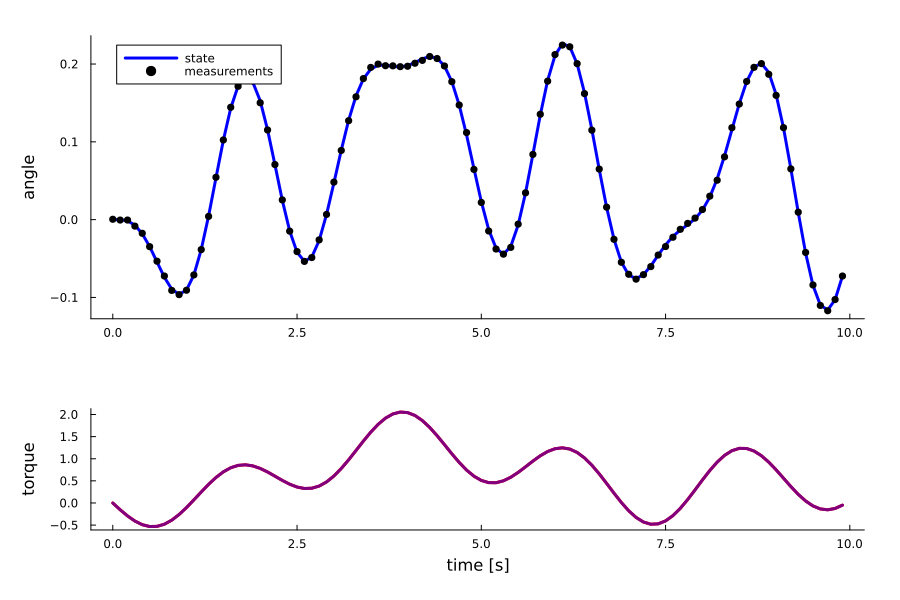

In [6]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Experiments

In [7]:
# Experiment specification 
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 5

# NARX basis settings
H = 2
Ly = 2
Lu = 2
M = size(pol(zeros(Ly+Lu+1), degree=H),1);

# System specification
init_state = [0.0, 0.0];

# Agent specification
α0 = 1e2 # Must be larger than 1.0 
β0 = 1e-1
μ0 = 1e-8ones(M)
Λ0 = 1/2*diagm(ones(M));
η = 1e-3

0.001

In [8]:
[mean(GammaShapeRate(α0, β0)) var(GammaShapeRate(α0, β0))]

1×2 Matrix{Float64}:
 1000.0  10000.0

### Expected Free Energy minimization

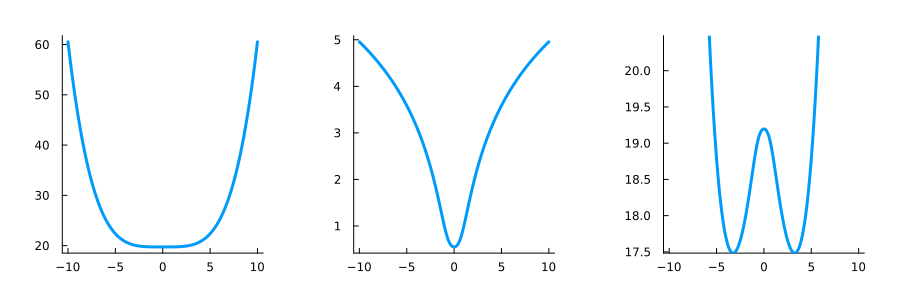

In [9]:
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Set goal priors for time horizon
goals = [Normal(3.141592./sys_mnorm, 0.5) for t in 1:T]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)   
                  
yb = zeros(Ly)
ub = zeros(Lu+1)

uu = range(sys_ulims[1], stop=sys_ulims[2], length=300)
J_MI = [mutualinfo(agent, yb, ub, u_) for u_ in uu]
J_CE = [crossentropy(agent, yb, ub, goals[1], u_) for u_ in uu]
J = J_CE - J_MI

p11 = plot(uu, J_CE)
p12 = plot(uu, J_MI)
p13 = plot(uu, J, ylims=(minimum(J), minimum(J)+3))
plot(p11, p12, p13, layout=(1,3), size=(900,300))


In [10]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     mnorm = sys_mnorm,
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Set goal priors for time horizon
goals = [Normal(3.141592*sys_mnorm, 0.5) for t in 1:T]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T,
                  control_prior_precision=η)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
F_EFE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
MI_EFE = zeros(N,T)
CE_EFE = zeros(N,T)
Nu = 200
J_MI = zeros(N,Nu)
J_CE = zeros(N,Nu)
JEFE = zeros(N,Nu)
urange = range(sys_ulims[1], stop=sys_ulims[2], length=Nu)

for k in 1:N    
    
    # Update parameter beliefs
    y_EFE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[k] = agent.free_energy
    push!( μ_EFE, agent.μ )
    push!( Λ_EFE, agent.Λ )
    push!( α_EFE, agent.α )
    push!( β_EFE, agent.β )
    
    # Optimal control
    policy = minimizeEFE(agent, goals, u_0=zeros(T), time_limit=30., control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy

    MI_EFE[k,:] = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_t) for u_t in policy]
    CE_EFE[k,:] = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_t) for u_t in policy]

    J_MI[k,:] = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
    J_CE[k,:] = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange]
    JEFE[k,:] = J_CE[k,:] .- J_MI[k,:]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_EFE[k+1])
    z_EFE[:,k] = pendulum.state
    
end

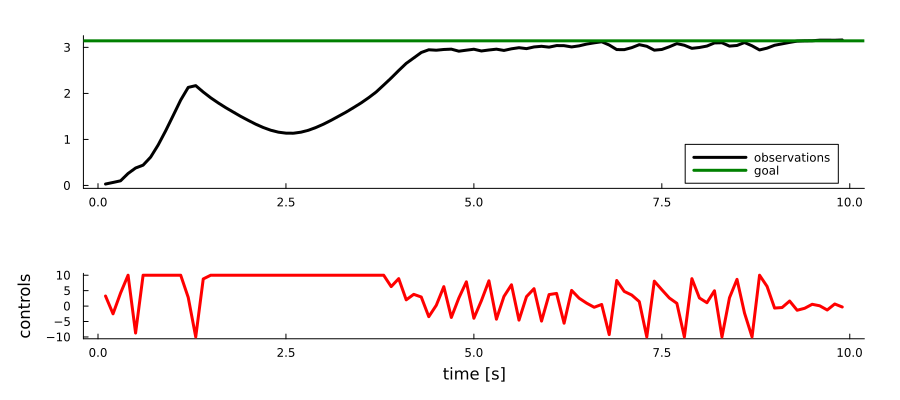

In [11]:
p1 = plot(tsteps[2:end], y_EFE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [12]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-EFE-1Pendulum-trial.png"

In [13]:
# save("results/EFE.jld", "y_EFE", y_EFE, "z_EFE", z_EFE, "u_EFE", u_EFE, 
#     "pred_m", pred_m, "pred_v", pred_v, "goals_m", mean.(goals), "goals_v", var.(goals),
#     "sys_ulims", sys_ulims, "tsteps", tsteps, "T", T)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-EFE-1Pendulum-planning.gif")
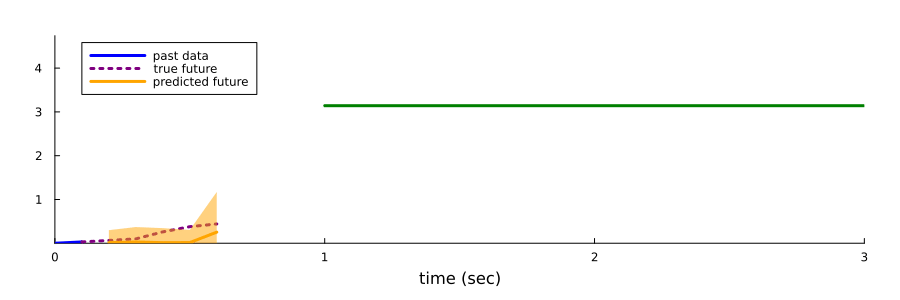

In [18]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=10)

### Quadratic cost with regularization

In [19]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     mnorm = sys_mnorm,
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T,
                  control_prior_precision=η)

# Preallocate
y_QCR = zeros(N)
z_QCR = zeros(2,N)
u_QCR = zeros(N+T)
μ_QCR = [μ0]
Λ_QCR = [Λ0]
α_QCR = [α0]
β_QCR = [β0]
F_QCR = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
J_QCR = zeros(N,T)
Nu = 200
J_QCR = zeros(N,Nu)
urange = range(sys_ulims[1], stop=sys_ulims[2], length=Nu)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_QCR[k] = pendulum.sensor
    NARXAgents.update!(agent, y_QCR[k], u_QCR[k])
    F_QCR[k] = agent.free_energy
    push!( μ_QCR, agent.μ )
    push!( Λ_QCR, agent.Λ )
    push!( α_QCR, agent.α )
    push!( β_QCR, agent.β )
    
    # Optimal control
    policy = minimizeQCR(agent, goals, u_0=zeros(T), time_limit=30.,control_lims=sys_ulims)
    u_QCR[k+1:k+T] = policy

    J_QCR[k,:] = [QCR(agent, agent.ybuffer, agent.ubuffer, goals[1], u_t)+η*u_t^2 for u_t in urange]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_QCR[k+1])
    z_QCR[:,k] = pendulum.state
    
end

Progress:   2%|▉                                        |  ETA: 0:04:15

Progress:  30%|████████████▎                            |  ETA: 0:00:16

Progress:  33%|█████████████▌                           |  ETA: 0:00:14

Progress:  34%|██████████████                           |  ETA: 0:00:14

Progress:  36%|██████████████▊                          |  ETA: 0:00:13

Progress:  38%|███████████████▋                         |  ETA: 0:00:12

Progress:  40%|████████████████▍                        |  ETA: 0:00:12

Progress:  47%|███████████████████▎                     |  ETA: 0:00:09

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:07

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:05

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:03

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


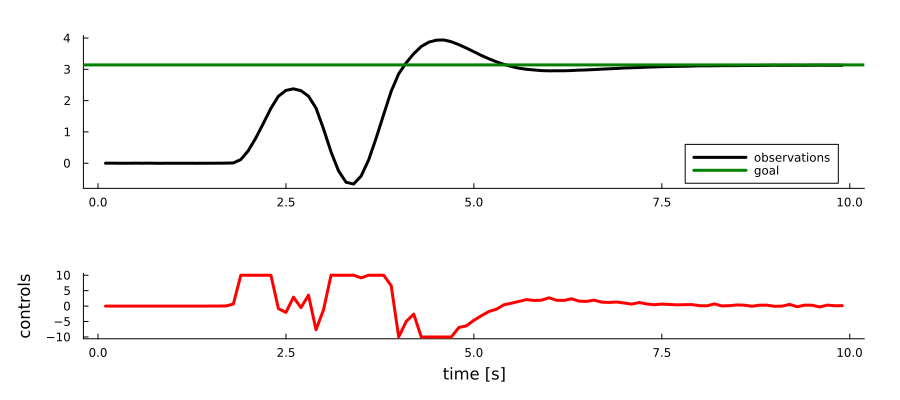

In [20]:
p1 = plot(tsteps[2:end], y_QCR[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(tsteps[2:end], u_QCR[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [21]:
savefig("figures/NARX-QCR-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-MSE-1Pendulum-trial.png"

In [ ]:
save("results/QCR.jld", "y_QCR", y_QCR, "z_QCR", z_QCR, "u_QCR", u_QCR, 
    "pred_m", pred_m, "pred_v", pred_v, "goals_m", mean.(goals), "goals_v", var.(goals),
    "sys_ulims", sys_ulims, "tsteps", tsteps, "T", T)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-MSE-1Pendulum-planning.gif")
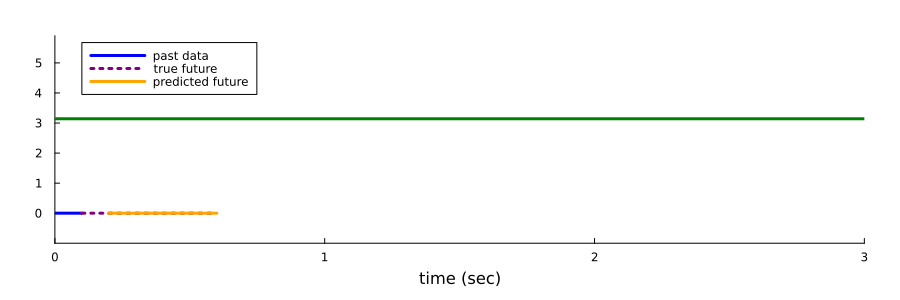

In [25]:
limsb = [minimum(y_QCR)*1.5, maximum(y_QCR)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_QCR[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_QCR[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_QCR[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_QCR[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-QCR-1Pendulum-planning.gif", fps=24)

### Comparisons

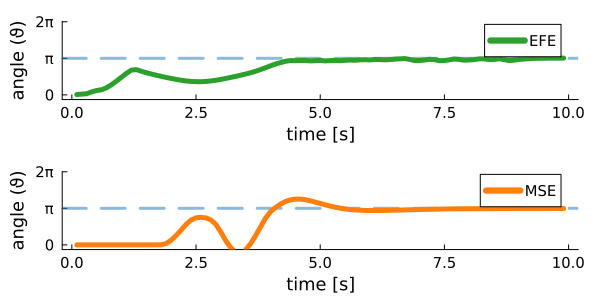

In [26]:
p1 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_QCR[2:end], linewidth=5, color=palette(:tab10)[2], label="QCR")

p2 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_EFE[2:end], linewidth=5, color=palette(:tab10)[3], label="EFE")

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

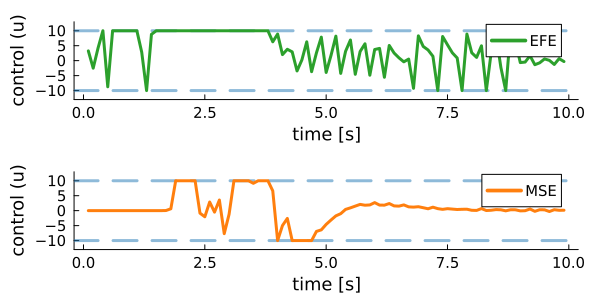

In [27]:
p1 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_QCR[2:end-T], linewidth=3, color=palette(:tab10)[2], label="QCR", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

p2 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_EFE[2:end-T], linewidth=3, color=palette(:tab10)[3], label="EFE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)